# Donwload the data

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
import kaggle
import tensorflow as tf
import pandas as pd

In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Preprocessing of Data, Tokenization and Numericalization:

In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 60000
sequence_length = 200

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
#text_ds = dataset.map(lambda x, y: x)
vectorize_layer.adapt(dataset.review)

In [ ]:
len(vectorize_layer.get_vocabulary())

60000

In [ ]:
input_data = ["This is an example sentence"]
transformed_data = vectorize_layer(input_data)
print(transformed_data)

tf.Tensor(
[[  11    7   33  462 3813    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  

In [ ]:
embedding_layer = tf.keras.layers.Embedding(60000, 16)

In [ ]:
embedding_layer(transformed_data).shape

TensorShape([1, 200, 16])

In [ ]:
Labels = []
for i in range(len(dataset.sentiment)):
  if dataset.sentiment[i] == "positive":
    Labels.append(1)
  else:
    Labels.append(0)

In [ ]:
df = pd.DataFrame({'Column1': dataset.sentiment, 'Column2': Labels})

In [ ]:
df.head()

,Column1,Column2
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [ ]:
Inputs = vectorize_layer(dataset.review)

In [ ]:
Labels = df.Column2

In [ ]:
# Create a TensorFlow dataset from the vectorized data
Inputs = tf.data.Dataset.from_tensor_slices(Inputs)
Labels = tf.data.Dataset.from_tensor_slices(Labels)

In [ ]:
dataset = tf.data.Dataset.zip((Inputs, Labels))
dataset

<_ZipDataset element_spec=(TensorSpec(shape=(200,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#Training and Validation data split :
dataset = dataset.shuffle(len(dataset))
train_size = int(0.8 * len(dataset))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
batch_size = 128

# Batch the dataset
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
len(train_dataset)

313

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# RNN Long Short Term Memory

In [ ]:
Model = Sequential([
    tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()),output_dim=128, input_length=200),
    tf.keras.layers.LSTM(128,activation = "tanh", return_sequences=True),
    tf.keras.layers.LSTM(128,activation = "tanh"),
    tf.keras.layers.Dense(128,activation = "tanh"),
    tf.keras.layers.Dense(1,activation = "sigmoid")
    ])

In [ ]:
#Learning rate scheduler:
def LR_scheduler(epoch):
    lr = 0.0005
    lr = lr*(1-0.4)**(epoch)
    return lr

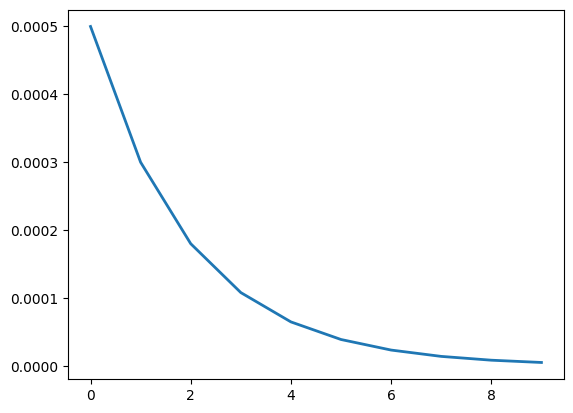

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = []
y = []
for epoch in range(10):
  y.append(LR_scheduler(epoch))
  x.append(epoch)

fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)


plt.show()

In [ ]:
y

[0.0005,
 0.0003,
 0.00017999999999999998,
 0.00010799999999999998,
 6.48e-05,
 3.8879999999999994e-05,
 2.3327999999999994e-05,
 1.3996799999999998e-05,
 8.398079999999997e-06,
 5.038847999999999e-06]

In [ ]:
Model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(LR_scheduler)

In [ ]:
Model.fit(train_dataset,epochs=10,callbacks=[callback],validation_data=val_dataset)

Epoch 1/10
313/313 [==============================] - 73s 203ms/step - loss: 0.4891 - accuracy: 0.7323 - val_loss: 0.2329 - val_accuracy: 0.9138 - lr: 5.0000e-04
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 0.2156 - accuracy: 0.9197 - val_loss: 0.1750 - val_accuracy: 0.9390 - lr: 3.0000e-04
Epoch 3/10
313/313 [==============================] - 10s 32ms/step - loss: 0.1357 - accuracy: 0.9546 - val_loss: 0.1460 - val_accuracy: 0.9526 - lr: 1.8000e-04
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 0.0901 - accuracy: 0.9740 - val_loss: 0.1265 - val_accuracy: 0.9632 - lr: 1.0800e-04
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.0670 - accuracy: 0.9833 - val_loss: 0.1250 - val_accuracy: 0.9671 - lr: 6.4800e-05
Epoch 6/10
313/313 [==============================] - 10s 32ms/step - loss: 0.0529 - accuracy: 0.9882 - val_loss: 0.1198 - val_accuracy: 0.9693 - lr: 3.8880e-05
Epoch 7/10
313/313 [=============

# Validation of training

In [ ]:
Model.evaluate(val_dataset)

79/79 [==============================] - 1s 12ms/step - loss: 0.1198 - accuracy: 0.9700


[0.11978285014629364, 0.9700000286102295]

In [ ]:
predictions = Model.predict(val_dataset)

79/79 [==============================] - 1s 10ms/step


In [ ]:
predictions

array([[0.00259744],
       [0.011048  ],
       [0.00149299],
       ...,
       [0.9980856 ],
       [0.9976526 ],
       [0.03005823]], dtype=float32)

In [ ]:
predictions = np.round(predictions).astype(int).flatten().tolist()

print(predictions)

[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 

In [ ]:
Real_predictions = []

for _, outputs in val_dataset:
    Real_predictions.extend(outputs.numpy().tolist())

print(Real_predictions)

[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 

In [ ]:
j = 0
n = 0
for i in range(len(predictions)):
  if predictions[i] == Real_predictions[i]:
    j = j + 1
  else:
    n = n + 1


print("There are: ", j ," True predictions")
print("There are: ", n ," False predictions")
print("Accuracy = ",j/(j+n),"%")

There are:  9700  True predictions
There are:  300  False predictions
Accuracy =  0.97 %
